In [ ]:
import ee
import geemap
import numpy
import requests
import io
import numpy as np
import geopandas as gpd
import random
from shapely.geometry import Point
import pickle
from PIL import Image
import os
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor, as_completed
import math
import cv2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.11/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [ ]:
# prompt: mount gdrive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ee.Authenticate()

In [ ]:
ee.Initialize(project='ee-isekalala')

In [ ]:
def ee_bytes_to_img(pixel_data, num_channels):
  img = np.array([[float(x) for x in pixel] for pixel in pixel_data.ravel()])
  img = img.reshape(pixel_data.shape[0], pixel_data.shape[1], num_channels)
  return img

def mask_s2_clouds(image):
  """Masks clouds in a Sentinel-2 image using the QA band.

  Args:
      image (ee.Image): A Sentinel-2 image.

  Returns:
      ee.Image: A cloud-masked Sentinel-2 image.
  """
  qa = image.select('QA60')

  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloud_bit_mask = 1 << 10
  cirrus_bit_mask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
  mask = (
      qa.bitwiseAnd(cloud_bit_mask)
      .eq(0)
      .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
  )

  return image.updateMask(mask).divide(10000)

def get_sentinel_2_pixels(region, year, scale_m=10):
  yr = str(year)
  sentinel2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
              .filterBounds(region) \
              .filterDate(yr + '-01-01', yr + '-12-31') \
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
              .map(mask_s2_clouds) \
              .median()

  url = sentinel2.getDownloadUrl({
    'bands': ['B4', 'B3', 'B2'], #red, green, blue bands respectively
    'region': region,
    'scale': scale_m,
    'format': 'NPY'})
  response = requests.get(url)
  data = numpy.load(io.BytesIO(response.content), allow_pickle=True)
  img = ee_bytes_to_img(data, 3)
  return np.clip(img, 0, 1)

In [ ]:
def get_open_buildings_pixels(region, year, scale_m=10):
  yr = str(year)
  buildings = ee.ImageCollection('GOOGLE/Research/open-buildings-temporal/v1') \
              .filterBounds(region) \
              .filterDate(yr + '-01-01', yr + '-12-31') \
              .first()
  url = buildings.getDownloadUrl({
    'bands': ['building_presence'],
    'region': region,
    'scale': scale_m,
    'format': 'NPY'
  })
  response = requests.get(url)
  data = numpy.load(io.BytesIO(response.content), allow_pickle=True)
  img = ee_bytes_to_img(data, 1)
  return np.clip(img, 0, 1)

In [ ]:
def get_open_buildings_counts(region, year, scale_m=1):
  imageCollection = ee.ImageCollection('GOOGLE/Research/open-buildings-temporal/v1')
  yr = str(year)
  mosaic = imageCollection.filterBounds(region).filterDate(yr + '-01-01', yr + '-12-31').mosaic()

  #epoch_s = ee.Date(ee.String(yr + '-06-30'), 'America/Los_Angeles').millis().divide(1000)
  #mosaic = imageCollection.filter(ee.Filter.eq('inference_time_epoch_s', epoch_s)).mosaic()
  count = mosaic.reduceRegion(ee.Reducer.sum(), region, scale_m, crs= region.projection()) \
          .getNumber('building_fractional_count') \
          .multiply(ee.Number(scale_m * 2).pow(2))
          # Since the pyramiding policy is mean, we need to multiply by
          # (scale_m * 2) ** 2 to recover sum at original 50cm resolution.
  return count.getInfo()

In [ ]:
def get_dw_pixels(region, year, scale_m=10):
  yr = str(year)
  buildings = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1') \
              .filterBounds(region) \
              .filterDate(yr + '-01-01', yr + '-12-31') \
              .median()
  url = buildings.getDownloadUrl({
    'bands': ['built', 'crops', 'water', 'trees', 'grass'],
    'region': region,
    'scale': scale_m,
    'format': 'NPY'
  })
  response = requests.get(url)
  data = numpy.load(io.BytesIO(response.content), allow_pickle=True)
  return ee_bytes_to_img(data, 5)

# Inspecting function calls, preliminary analysis

In [ ]:
lat, lng = 0.3622178,32.6299127

In [ ]:
buffer_distance = 100  # 100 meters in each direction

# Create a point geometry for the given latitude and longitude
point = ee.Geometry.Point([lng, lat])

# Create a bounding box (rectangle) around the point with a 200 x 200 meter area
region = point.buffer(buffer_distance).bounds()

# Print the coordinates of the region
print('Region coordinates:', region.getInfo())

Region coordinates: {'geodesic': False, 'type': 'Polygon', 'coordinates': [[[32.62902012037467, 0.3613182592241371], [32.63080811302377, 0.3613182592241371], [32.63080811302377, 0.3631176865951727], [32.62902012037467, 0.3631176865951727], [32.62902012037467, 0.3613182592241371]]]}


In [ ]:
arr = get_dw_pixels(region, 2024, 1)

IndexError: index 5 is out of bounds for axis 2 with size 5

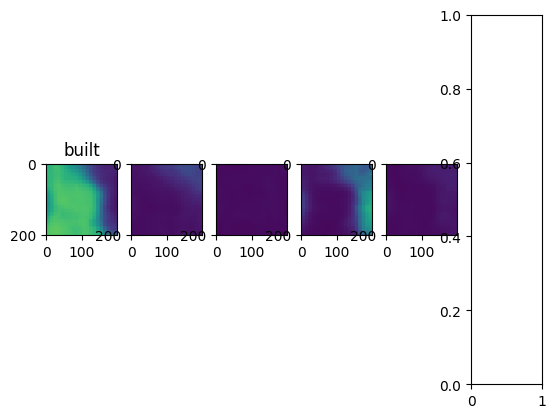

In [ ]:
plt.subplot(1, 6, 1)
plt.imshow(arr[:, :, 0], vmin=0, vmax=1)
plt.title('built')
plt.subplot(1, 6, 2)
plt.imshow(arr[:, :, 1], vmin=0, vmax=1)
plt.subplot(1, 6, 3)
plt.imshow(arr[:, :, 2], vmin=0, vmax=1)
plt.subplot(1, 6, 4)
plt.imshow(arr[:, :, 3], vmin=0, vmax=1)
plt.subplot(1, 6, 5)
plt.imshow(arr[:, :, 4], vmin=0, vmax=1)
plt.subplot(1, 6, 6)
plt.imshow(arr[:, :, 4], vmin=0, vmax=1)


In [ ]:
%%time
target_year = 2023
scale_m = 1

input_1 = get_sentinel_2_pixels(
        region, target_year - 1, scale_m=scale_m)
input_2 = get_open_buildings_pixels(
        region, target_year - 2, scale_m=scale_m)
input_2_count = get_open_buildings_counts(region, target_year - 2)
input_3 = get_open_buildings_pixels(
        region, target_year - 3, scale_m=scale_m)
input_4 = get_dw_pixels(region, target_year-1, 10)


target_count = get_open_buildings_counts(region, target_year)
regression_target = target_count - input_2_count

CPU times: user 587 ms, sys: 22.6 ms, total: 609 ms
Wall time: 8.34 s


In [ ]:
target = get_open_buildings_pixels(region, target_year, scale_m=scale_m)

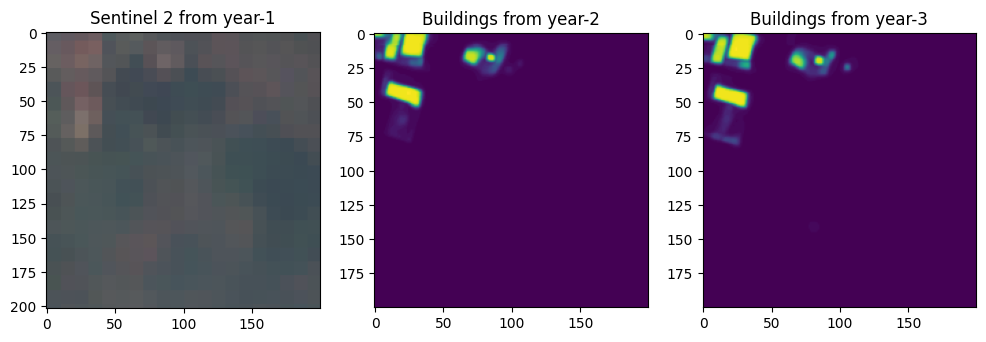

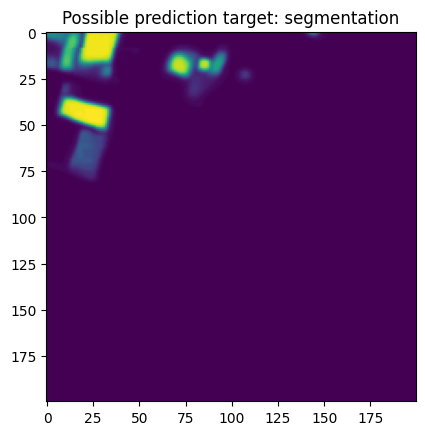

In [ ]:
plt.subplot(1, 3, 1)
plt.imshow(input_1 * 3)
plt.title('Sentinel 2 from year-1')
plt.subplot(1, 3, 2)
plt.imshow(input_2)
plt.title('Buildings from year-2')
plt.subplot(1, 3, 3)
plt.imshow(input_3)
plt.title('Buildings from year-3')
plt.gcf().set_size_inches(12, 4)
plt.show()

plt.imshow(target)
plt.title('Possible prediction target: segmentation');

(array([ 6410.,  6900., 18020., 41255., 39108.,  6257.,  1660.,   790.,
          400.,   400.]),
 array([0.0777  , 0.086255, 0.09481 , 0.103365, 0.11192 , 0.120475,
        0.12903 , 0.137585, 0.14614 , 0.154695, 0.16325 ]),
 <BarContainer object of 10 artists>)

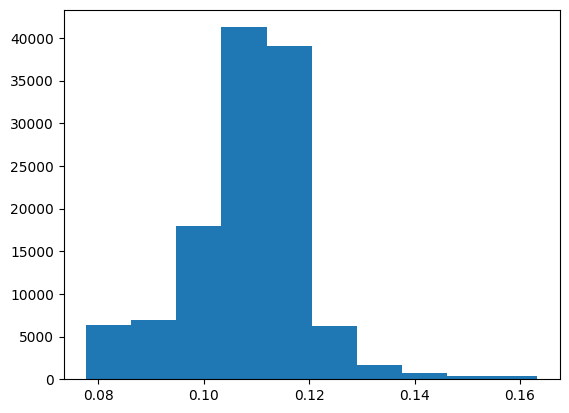

In [ ]:
plt.hist(input_1.flatten())

In [ ]:
# Simpler prediction target: how much change between target_year-2 and target_year
# in square metres.
regression_target = target_count - input_2_count
print(regression_target)

1.5907448894381844


# Generate coordinate samples from Uganda shapefile

In [ ]:
def sample_points_in_polygon(polygon, num_points):
    """Generate random points within a polygon."""
    min_x, min_y, max_x, max_y = polygon.bounds
    points = []

    while len(points) < num_points:
        # Generate a random point within the bounds of the polygon
        random_point = Point(random.uniform(min_x, max_x), random.uniform(min_y, max_y))
        # Check if the point is inside the polygon
        if polygon.contains(random_point):
            points.append(random_point)

    return points

def generate_train_test_sets(shapefile_path, total_samples=100000, train_percent=0.8, test_percent=0.2):
    # Load the shapefile
    gdf = gpd.read_file(shapefile_path)

    # Ensure the train_percent and test_percent add up to 1.0
    assert train_percent + test_percent == 1.0, "Train and test percentages must add up to 1.0"

    # Randomly select subcounties for training and test sets
    subcounty_count = len(gdf)
    num_train_subcounties = int(subcounty_count * train_percent)
    train_subcounties = gdf.sample(num_train_subcounties, random_state=42)  # Random but reproducible
    test_subcounties = gdf.drop(train_subcounties.index)

    # Determine the number of points for each set
    train_samples = int(total_samples * train_percent)
    test_samples = total_samples - train_samples

    # Determine how many points to sample per subcounty for training and test sets
    points_per_train_subcounty = train_samples // num_train_subcounties
    points_per_test_subcounty = test_samples // len(test_subcounties)

    # Collect points for training set
    train_points = []
    for _, subcounty in train_subcounties.iterrows():
        polygon = subcounty.geometry
        points_in_subcounty = sample_points_in_polygon(polygon, points_per_train_subcounty)
        train_points.extend(points_in_subcounty)

    # Collect points for test set
    test_points = []
    for _, subcounty in test_subcounties.iterrows():
        polygon = subcounty.geometry
        points_in_subcounty = sample_points_in_polygon(polygon, points_per_test_subcounty)
        test_points.extend(points_in_subcounty)

    # Ensure we have exactly the number of samples requested for each set
    # Handling rounding issues for training set
    if len(train_points) > train_samples:
        train_points = train_points[:train_samples]
    elif len(train_points) < train_samples:
        extra_points_needed = train_samples - len(train_points)
        additional_samples = sample_points_in_polygon(train_subcounties.iloc[-1].geometry, extra_points_needed)
        train_points.extend(additional_samples)

    # Handling rounding issues for test set
    if len(test_points) > test_samples:
        test_points = test_points[:test_samples]
    elif len(test_points) < test_samples:
        extra_points_needed = test_samples - len(test_points)
        additional_samples = sample_points_in_polygon(test_subcounties.iloc[-1].geometry, extra_points_needed)
        test_points.extend(additional_samples)

    # Convert the points to a list of (lat, lon, index) tuples for both sets
    train_coords = [(point.y, point.x, i) for i, point in enumerate(train_points)] # lat, lon
    test_coords = [(point.y, point.x, i) for i, point in enumerate(test_points)] # lat, lon

    return train_coords, test_coords


# Example usage
shapefile_path = '/content/drive/Shareddrives/Sunbird AI/Projects/GIZ Mini-grid Identification/Phase II/Data/administrative areas/subcounties/UGA admin4.shp'
train_set, test_set = generate_train_test_sets(shapefile_path)

# Print first 5 sample points for the training set
print("Training set samples:")
for i, (lat, lon, idx) in enumerate(train_set[:5]):
    print(f"Sample {i+1}: Latitude = {lat}, Longitude = {lon}")

# Print first 5 sample points for the test set
print("\nTest set samples:")
for i, (lat, lon, idx) in enumerate(test_set[:5]):
    print(f"Sample {i+1}: Latitude = {lat}, Longitude = {lon}")


Training set samples:
Sample 1: Latitude = 1.786758818381411, Longitude = 32.28934048169989
Sample 2: Latitude = 1.8641933651403877, Longitude = 32.36149099536126
Sample 3: Latitude = 1.9352107705488377, Longitude = 32.411548171357026
Sample 4: Latitude = 1.7796227266335307, Longitude = 32.26314957263768
Sample 5: Latitude = 1.965563478333776, Longitude = 32.42315006323149

Test set samples:
Sample 1: Latitude = 2.3827350470897524, Longitude = 30.910171996269302
Sample 2: Latitude = 2.4129754581526357, Longitude = 30.932403524972166
Sample 3: Latitude = 2.4097473857188656, Longitude = 30.929617899762178
Sample 4: Latitude = 2.3911818991741254, Longitude = 30.94586853120184
Sample 5: Latitude = 2.4148860184770022, Longitude = 30.948521033504306



# Pulling the Data

In [ ]:
# prompt: open train set and test set from pickle

import pickle

# Load the training set
with open('/content/drive/Shareddrives/Sunbird AI/Projects/GIZ Mini-grid Identification/Phase II/Code/model training/train_set_coords.pkl', 'rb') as f:
    train_set = pickle.load(f)

# Load the test set
with open('/content/drive/Shareddrives/Sunbird AI/Projects/GIZ Mini-grid Identification/Phase II/Code/model training/test_set_coords.pkl', 'rb') as f:
    test_set = pickle.load(f)

# Now you can work with train_set and test_set
print("Training set loaded successfully.")
print(f"Number of samples in training set: {len(train_set)}")

print("\nTest set loaded successfully.")
print(f"Number of samples in test set: {len(test_set)}")

Training set loaded successfully.
Number of samples in training set: 80000

Test set loaded successfully.
Number of samples in test set: 20000


In [ ]:
def get_composite_data(region, year, scale_m=1):
    # Sentinel-2 composite (e.g., for year-1)
    s2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
          .filterBounds(region) \
          .filterDate(f'{year-1}-01-01', f'{year-1}-12-31') \
          .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
          .map(mask_s2_clouds) \
          .median() \
          .select(['B4', 'B3', 'B2']).unitScale(0, 1)  # 3 bands

    # We want to predict for 2025, OB goes up until 2023, so we take the Open Buildings composites for three previous years -1
    ob_y2 = ee.ImageCollection('GOOGLE/Research/open-buildings-temporal/v1') \
             .filterBounds(region).filterDate(f'{year-2}-01-01', f'{year-1}-12-31').mosaic()
    ob_y3 = ee.ImageCollection('GOOGLE/Research/open-buildings-temporal/v1') \
             .filterBounds(region).filterDate(f'{year-3}-01-01', f'{year-2}-12-31').mosaic()
    ob_y4 = ee.ImageCollection('GOOGLE/Research/open-buildings-temporal/v1') \
             .filterBounds(region).filterDate(f'{year-4}-01-01', f'{year-3}-12-31').mosaic()

    # Compute building count differences directly on server side.
    # Note: Adjust the reducer and multiplication factor as needed.
    count_y2 = ob_y2.reduceRegion(ee.Reducer.sum(), region, scale_m, crs= region.projection()).getNumber('building_fractional_count').multiply(ee.Number(scale_m * 2).pow(2))
    count_y3 = ob_y3.reduceRegion(ee.Reducer.sum(), region, scale_m, crs= region.projection()).getNumber('building_fractional_count').multiply(ee.Number(scale_m * 2).pow(2))
    count_y4 = ob_y4.reduceRegion(ee.Reducer.sum(), region, scale_m, crs= region.projection()).getNumber('building_fractional_count').multiply(ee.Number(scale_m * 2).pow(2))
    diff1 = count_y2.subtract(count_y3)
    diff1_img = ee.Image.constant(diff1).rename('diff1')
    diff2 = count_y3.subtract(count_y4)
    diff2_img = ee.Image.constant(diff2).rename('diff2')

    # Dynamic World composite
    dw = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1') \
         .filterBounds(region).filterDate(f'{year-1}-01-01', f'{year-1}-12-31') \
         .median() \
         .select(['built', 'crops', 'water', 'trees', 'grass'])  # 5 bands

    # target
    imageCollection = ee.ImageCollection('GOOGLE/Research/open-buildings-temporal/v1').filterBounds(region)
    count_y0 = imageCollection.filterDate(f'{year}-01-01', f'{year}-12-31').mosaic() \
                .reduceRegion(ee.Reducer.sum(), region, scale_m, crs= region.projection()) \
                .getNumber('building_fractional_count').multiply(ee.Number(scale_m * 2).pow(2))
    count_y1 = imageCollection.filterDate(f'{year-1}-01-01', f'{year-1}-12-3').mosaic() \
                .reduceRegion(ee.Reducer.sum(), region, scale_m, crs= region.projection()) \
                .getNumber('building_fractional_count').multiply(ee.Number(scale_m * 2).pow(2))
    diff = count_y0.subtract(count_y1)
    target_img = ee.Image.constant(diff).rename('target')


    # Combine all into a single multi-band image
    composite = s2.addBands(ob_y2.select(['building_presence']).clamp(0, 1)) \
                  .addBands(ob_y3.select(['building_presence']).clamp(0, 1)) \
                  .addBands(diff1_img) \
                  .addBands(diff2_img) \
                  .addBands(dw) \
                  .addBands(target_img)

    return composite

In [ ]:
%%time
buffer_distance = 100
point = ee.Geometry.Point([lng, lat])
region = point.buffer(buffer_distance).bounds()
scale_m = 1

composite = get_composite_data(region, 2023, scale_m)
url = composite.getDownloadUrl({
    'bands': ['B4', 'B3', 'B2', 'building_presence', 'building_presence_1', 'diff1', 'diff2', 'built', 'crops', 'water', 'trees', 'grass', 'target'],
    'region': region,
    'dimensions': '200x200',
    'format': 'NPY'
})
response = requests.get(url)
data = np.load(io.BytesIO(response.content), allow_pickle=True)
resized = ee_bytes_to_img(data, 13)

CPU times: user 582 ms, sys: 19.8 ms, total: 602 ms
Wall time: 2.8 s


In [ ]:
def get_reg_target(region, year, scale_m):
  imageCollection = ee.ImageCollection('GOOGLE/Research/open-buildings-temporal/v1').filterBounds(region)
  count_y0 = imageCollection.filterDate(f'{year}-01-01', f'{year}-12-31').mosaic() \
              .reduceRegion(ee.Reducer.sum(), region, scale_m, crs= region.projection()) \
              .getNumber('building_fractional_count').multiply(ee.Number(scale_m * 2).pow(2))
  count_y1 = imageCollection.filterDate(f'{year-1}-01-01', f'{year-1}-12-3').mosaic() \
              .reduceRegion(ee.Reducer.sum(), region, scale_m, crs= region.projection()) \
              .getNumber('building_fractional_count').multiply(ee.Number(scale_m * 2).pow(2))
  diff = count_y0.subtract(count_y1)
  return diff.getInfo()

In [ ]:
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor

def process_point(lat, lng, year):
    buffer_distance = 100
    point = ee.Geometry.Point([lng, lat])
    region = point.buffer(buffer_distance).bounds()
    scale_m = 1

    # get input data + target. consistent 200x200 specified in dimensions

    composite = get_composite_data(region, 2023, scale_m)
    url = composite.getDownloadUrl({
        'bands': ['B4', 'B3', 'B2', 'building_presence', 'building_presence_1', 'diff1', 'diff2', 'built', 'crops', 'water', 'trees', 'grass', 'target'],
        'region': region,
        'dimensions': '200x200',
        'format': 'NPY'
    })
    response = requests.get(url)
    data = np.load(io.BytesIO(response.content), allow_pickle=True)
    data = ee_bytes_to_img(data, 13)

    # get input and  target

    input_data, regression_target = data[:,:,:12], data[0,0,12]

    return input_data, regression_target

In [ ]:
%%time
input_data, target = process_point(lat, lng, 2023)

CPU times: user 432 ms, sys: 17.5 ms, total: 449 ms
Wall time: 3.07 s


# Get global min and max values for pixels for 8bit scaling. Run only if new values need to be generated

In [ ]:
# prompt: randomly shuffle train_set and test_set with seed

import random

# Assuming train_set and test_set are lists of tuples (lat, lon, index)
def shuffle_sets(train_set, test_set, seed=42):
  random.seed(seed)
  random.shuffle(train_set)
  random.shuffle(test_set)
  return train_set, test_set

# Example usage (replace with your actual train_set and test_set)
train_set, test_set = shuffle_sets(train_set, test_set)

In [ ]:
# prompt: create a function that performs process_point for 1000 datapoints from the train_set. The goal is to find the maximum and minimum value for each of the 12 bands. Find the most efficient way to do this, and if possible parralellize it to speed up computation

import concurrent.futures

def process_datapoints(datapoints, year):
    """Processes a list of datapoints and finds min/max for each band."""

    min_values = [float('inf')] * 12  # Initialize with positive infinity
    max_values = [float('-inf')] * 12 # Initialize with negative infinity

    # Use a ThreadPoolExecutor for parallel processing
    with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
        futures = [executor.submit(process_point, lat, lng, year) for lat, lng, _ in datapoints]

        for future in concurrent.futures.as_completed(futures):
            try:
                input_data, _ = future.result()
                # Iterate through the bands (channels) of the input_data
                for band in range(input_data.shape[2]):
                    band_data = input_data[:, :, band].flatten()
                    min_values[band] = min(min_values[band], np.min(band_data))
                    max_values[band] = max(max_values[band], np.max(band_data))

            except Exception as e:
                print(f"An error occurred during processing: {e}")

    return min_values, max_values


# Example usage: Process the first 1000 points from train_set
year = 2022 # Example year, replace with your desired year
min_max_values = process_datapoints(train_set[:2000], year)
min_values, max_values = min_max_values
print("Minimum values for each band:", min_values)
print("Maximum values for each band:", max_values)


Minimum values for each band: [0.03449999913573265, 0.05469999834895134, 0.06800000369548798, 0.0, 0.0, -20.543866144199043, -28.30534877019631, 0.0, 0.0, 0.0, 0.0, 0.0]
Maximum values for each band: [0.7121999859809875, 0.6672000288963318, 0.6872000098228455, 1.0, 1.0, 50.4115640683834, 39.42864027752104, 0.7834583707153797, 0.6432805603835732, 0.7570242718793452, 0.7744354496244341, 0.6975805942201987]


# Gathering the dataset

In [ ]:
def rescale_to_8bit(image_data, mins, maxs):
    # Compute the range for each channel
    diffs = maxs - mins

    # Apply scaling per channel. Assumes image_data has shape (..., channels)
    scaled_data = 255 * (image_data - mins) / diffs

    # Clip values to ensure they lie between 0 and 255, then convert to uint8
    scaled_data = np.clip(scaled_data, 0, 255)
    return scaled_data.astype(np.uint8)

#global mins and maxs arrays for your 12 channels:
mins = np.array([0.03449999913573265, 0.05469999834895134, 0.06800000369548798,
                 0.0, 0.0, -20.543866144199043, -28.30534877019631,
                 0.0, 0.0, 0.0, 0.0, 0.0])
maxs = np.array([0.7121999859809875, 0.6672000288963318, 0.6872000098228455,
                 1.0, 1.0, 50.4115640683834, 39.42864027752104,
                 0.7834583707153797, 0.6432805603835732, 0.7570242718793452, 0.7744354496244341, 0.6975805942201987])

In [ ]:
output_dir = '/content/exp_test_set_10_11250'
os.makedirs(output_dir, exist_ok=True)

# Save image data as JPEG
def save_as_jpeg(image_data, filename):
    img = Image.fromarray(image_data)
    img.save(filename, format="JPEG", quality=85)

# Process each point to a set of images
def process_and_save(lat, lng, output_filename_prefix, year):
    try:
        combined_data, target = process_point(lat, lng, year)

        # Rescale data for each channel to 8-bit
        rescaled_data = rescale_to_8bit(combined_data, mins, maxs)

        # Save each 3-channel group as a separate JPEG image
        for i in range(0, rescaled_data.shape[2], 3):
            channel_group = rescaled_data[..., i:i+3]
            if channel_group.shape[2] < 3:  # Pad if channels < 3
                channel_group = np.pad(channel_group, ((0, 0), (0, 0), (0, 3 - channel_group.shape[2])), 'constant')

            #lat_rounded = int(round(lat, 4) * 10000)
            #lng_rounded = int(round(lng, 4) * 10000)
            filename = f"{output_dir}/{output_filename_prefix}_{i//3}.jpg"
            save_as_jpeg(channel_group, filename)

            print(f"Saved {filename}")

        # save target as txt file
        target_filename = f"{output_dir}/{output_filename_prefix}_target.txt"
        with open(target_filename, 'w') as f:
            f.write(str(target))

    except Exception as e:
        print(f"Error processing {output_filename_prefix}: {e}")

In [ ]:
%%time
combined_data, target = process_point(lat, lng, 2020)

CPU times: user 461 ms, sys: 18.9 ms, total: 480 ms
Wall time: 3.14 s


Data from the Training set is called in batches of 10k from GEE. Each batch was split equally between the range of years to train, fom 2021-2022 inclusive. The Test set was tested only on the year 2023

In [ ]:
%%time
import pickle
from concurrent.futures import ThreadPoolExecutor, as_completed

#parallel process the process and save function, in such a way that the training set is split evenly by the number of years. For example, a training set of 80k
#coordinates and range of 4 years would mean that the first year takes the first 20k images, the second year takes the next 20k images, and so on

def parallel_process(region_set, years, max_workers=10):
  # Batch process, splitting region set equally based on the number of years
  batch_size = len(region_set) // len(years)
  for i, year in enumerate(years):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size if i < len(years) - 1 else len(region_set)
    batch = region_set[start_idx:end_idx]
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
      executor.map(lambda coord: process_and_save(*coord, year), batch)



# Define years and initiate parallel processing
years_to_process = [2023]  # Example range of years
parallel_process(test_set[10000:11250], years_to_process)

Streaming output truncated to the last 5000 lines.
Saved /content/exp_test_set_10_11250/4582_2.jpg
Saved /content/exp_test_set_10_11250/4582_3.jpg
Saved /content/exp_test_set_10_11250/8683_0.jpg
Saved /content/exp_test_set_10_11250/5624_0.jpg
Saved /content/exp_test_set_10_11250/5624_1.jpg
Saved /content/exp_test_set_10_11250/5624_2.jpg
Saved /content/exp_test_set_10_11250/5624_3.jpg
Saved /content/exp_test_set_10_11250/8683_1.jpg
Saved /content/exp_test_set_10_11250/8683_2.jpg
Saved /content/exp_test_set_10_11250/8683_3.jpg
Saved /content/exp_test_set_10_11250/18621_0.jpg
Saved /content/exp_test_set_10_11250/18621_1.jpg
Saved /content/exp_test_set_10_11250/18621_2.jpg
Saved /content/exp_test_set_10_11250/18621_3.jpg
Saved /content/exp_test_set_10_11250/18782_0.jpg
Saved /content/exp_test_set_10_11250/18782_1.jpg
Saved /content/exp_test_set_10_11250/18782_2.jpg
Saved /content/exp_test_set_10_11250/18782_3.jpg
Saved /content/exp_test_set_10_11250/15306_0.jpg
Saved /content/exp_test_set_

In [ ]:
!zip -r /content/exp_test_set_10_11250.zip /content/exp_test_set_10_11250

Streaming output truncated to the last 5000 lines.
  adding: content/exp_test_set_10_11250/15306_2.jpg (deflated 5%)
  adding: content/exp_test_set_10_11250/19148_0.jpg (deflated 9%)
  adding: content/exp_test_set_10_11250/16859_target.txt (stored 0%)
  adding: content/exp_test_set_10_11250/9360_target.txt (stored 0%)
  adding: content/exp_test_set_10_11250/18712_1.jpg (deflated 50%)
  adding: content/exp_test_set_10_11250/12691_2.jpg (deflated 17%)
  adding: content/exp_test_set_10_11250/5643_target.txt (stored 0%)
  adding: content/exp_test_set_10_11250/8067_target.txt (stored 0%)
  adding: content/exp_test_set_10_11250/11071_0.jpg (deflated 14%)
  adding: content/exp_test_set_10_11250/13017_target.txt (stored 0%)
  adding: content/exp_test_set_10_11250/11502_2.jpg (deflated 11%)
  adding: content/exp_test_set_10_11250/14494_1.jpg (deflated 65%)
  adding: content/exp_test_set_10_11250/12136_3.jpg (deflated 5%)
  adding: content/exp_test_set_10_11250/16298_1.jpg (deflated 54%)
  addin

In [ ]:
# prompt: download full test set

from google.colab import files
files.download('/content/full_test_set_0_10.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>